In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
pip install selfies

In [ ]:
pip install rdkit

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 34.3/34.3 MB 52.4 MB/s eta 0:00:00


In [ ]:
# === IMPORT ===
# PyTorch per deep learning
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

# SELFIES per conversione molecolare
import selfies as sf

# Pandas e altri strumenti di base
import pandas as pd
from collections import Counter

🔵 Carichiamo il Dataset preprocessato


In [ ]:

import pandas as pd
df_aug = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/augmented_selfies_dataset.csv")

# Tokenizza le stringhe SELFIES separandole in lista di simboli
df_aug["selfies_tokens"] = df_aug["selfies_str"].apply(lambda s: s.split(" "))

# Rinomina il DataFrame per compatibilità
augmented_data = df_aug


In [ ]:
'''
for i, row in augmented_data[:5].iterrows():
    print(f"Entry {i}:", row, "| Tipo:", type(row["selfies_str"]))
'''

Entry 0: selfies_str       [C] [O] [C] [=Branch1] [C] [=O] [C@@H1] [C] [C...
docking_score                                              -6.19542
selfies_tokens    [[C], [O], [C], [=Branch1], [C], [=O], [C@@H1]...
Name: 0, dtype: object | Tipo: <class 'str'>
Entry 1: selfies_str       [C] [=Branch1] [C] [=O] [Branch1] [Ring1] [O] ...
docking_score                                              -6.19542
selfies_tokens    [[C], [=Branch1], [C], [=O], [Branch1], [Ring1...
Name: 1, dtype: object | Tipo: <class 'str'>
Entry 2: selfies_str       [O] [Branch1] [C] [C] [C] [=C] [C] [Branch1] [...
docking_score                                              -6.19542
selfies_tokens    [[O], [Branch1], [C], [C], [C], [=C], [C], [Br...
Name: 2, dtype: object | Tipo: <class 'str'>
Entry 3: selfies_str       [N] [C] [Branch2] [Ring1] [O] [C] [=Branch1] [...
docking_score                                              -7.97568
selfies_tokens    [[N], [C], [Branch2], [Ring1], [O], [C], [=Bra...
Name: 3, dtyp

🔵 **Costruzione del vocabolario e encoding numerico**

In [ ]:

from collections import Counter

# Access the 'selfies_tokens' column directly and iterate over its values
all_tokens = [tok for tokens in augmented_data["selfies_tokens"] for tok in tokens]
token_counter = Counter(all_tokens)

# Costruzione vocabolario SELFIES
selfies_vocab = {tok: idx + 1 for idx, tok in enumerate(sorted(token_counter))}
selfies_vocab['<PAD>'] = 0
inv_selfies_vocab = {idx: tok for tok, idx in selfies_vocab.items()}

# Codifica numerica
def encode_selfies(tokens, vocab):
    return [vocab[tok] for tok in tokens]

# Use the 'selfies_tokens' and 'docking_score' columns for encoding and scores
encoded_sequences = [encode_selfies(tokens, selfies_vocab) for tokens in augmented_data["selfies_tokens"]]
docking_scores = augmented_data["docking_score"].tolist() # Convert docking scores to a list



🔵**SPLITTING CASUALE del DATASET**

Partendo dalle di datafrmes Panda :

* df['SELFIES_encoded'] → lista di sequenze numeriche

* df['Docking_scores'] (o Docking_scores_scaled) → target da predire

Opero una tripartizione dei dati secondo le percentuali:

1.  80% training

2.  10% validation

3.  10% test

In [ ]:
from sklearn.model_selection import train_test_split

# Estrazione delle liste
X = encoded_sequences
y = docking_scores # o Docking_scores_scaled y = df['Docking_scores_scaled'].tolist()


# Primo split: train vs temp (val+test)
X_train, X_temp, y_train, y_temp = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# Secondo split: val vs test
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.5, random_state=42
)

print(f"Train: {len(X_train)}  | Val: {len(X_val)}  | Test: {len(X_test)}")




Train: 486657  | Val: 60832  | Test: 60833


🔵**Preparazione del Dataset e del DataLoader PyTorch con padding dinamico.**

In [ ]:

# === 3 DATASET E DATALOADER CON PADDING ===
from torch.utils.data import Dataset, DataLoader
import torch

# === 1. Classe PyTorch Dataset ===
class DockingDataset(Dataset):
    def __init__(self, selfies_encoded, docking_scores):
        self.selfies_encoded = selfies_encoded
        self.docking_scores = docking_scores

    def __len__(self):
        return len(self.selfies_encoded)

    def __getitem__(self, idx):
        return self.selfies_encoded[idx], self.docking_scores[idx]

# === 2. Funzione per padding dinamico ===
def collate_fn(batch):
    """
    Prepara un batch:
    - paddando le sequenze alla stessa lunghezza
    - restituendo le lunghezze originali
    """
    sequences, scores = zip(*batch)
    lengths = [len(seq) for seq in sequences]
    max_len = max(lengths)

    # Applica padding con 0 (indice <PAD>)
    padded_sequences = [seq + [0] * (max_len - len(seq)) for seq in sequences]

    return (
        torch.tensor(padded_sequences, dtype=torch.long),
        torch.tensor(scores, dtype=torch.float32),
        lengths
    )

# === 3. Creazione dei dataset ===
train_dataset = DockingDataset(X_train, y_train)
val_dataset   = DockingDataset(X_val, y_val)
test_dataset  = DockingDataset(X_test, y_test)

# === 4. Creazione dei DataLoader ===
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True,  collate_fn=collate_fn)
val_loader   = DataLoader(val_dataset,   batch_size=32, shuffle=False, collate_fn=collate_fn)
test_loader  = DataLoader(test_dataset,  batch_size=32, shuffle=False, collate_fn=collate_fn)



In [ ]:
'''
# Ottieni un batch dal train_loader (per verifica)
sample_batch = next(iter(train_loader))

sequences, scores, lengths = sample_batch

print("Shape delle sequenze padded:", sequences.shape)
print("Primi 5 scores:", scores[:5])
print("Prime 5 lunghezze:", lengths[:5])

Shape delle sequenze padded: torch.Size([32, 53])
Primi 5 scores: tensor([-8.4788, -6.8734, -7.5062, -6.4379, -4.1521])
Prime 5 lunghezze: [44, 31, 38, 35, 36]


🔵**Definizione della rete neurale RNN.**

L'obiettivo è costruire un modello in PyTorch che:

* prenda in input le sequenze SMILES tokenizzate,

* le elabori con un Embedding Layer + LSTM,

* produca in output una stima del docking score (regressione).

├──►  Input: SMILES tokenizzati (con padding)

│

├──► Embedding Layer (trasforma token in vettori densi)

│

├──► LSTM (modella la sequenza chimica)

│

├──► Ultimo stato nascosto (embedding molecolare)

│

└──► Fully Connected Layer → Output: docking score




In [ ]:
#CLASSE DockingRNN


class DockingRNN(nn.Module):
#metodo costruttore
    def __init__(self, vocab_size, embedding_dim=128, hidden_dim=256, num_layers=2, dropout=0.3):
        super(DockingRNN, self).__init__()
#layer di embedding che trasforma gli indici dei token in vettori densi di dimensione embedding_dim con token <PAD> ignorato
        self.embedding = nn.Embedding(num_embeddings=vocab_size, embedding_dim=embedding_dim, padding_idx=0)
# LSTM riceve una sequenza di embedding ([batch, seq_len, embedding_dim])
        self.lstm = nn.LSTM(
            input_size=embedding_dim,
            hidden_size=hidden_dim,
            num_layers=num_layers,
            bidirectional = True,# <==== AGGIUNTO
            batch_first=True, #i batch sono nella forma [batch, seq, feature]
            dropout=dropout if num_layers > 1 else 0.0,  # dropout solo se >1 layer
        )

        self.dropout = nn.Dropout(dropout)

        self.fc = nn.Linear(hidden_dim * 2, 1)# <==== Cambiato output layer

    #metodo forward che definisce la propagazione in avanti del modello : riceve x come batch di sequenze codificatie in indici SELFIES
    def forward(self, x, lengths): #lengths: lunghezze originali delle sequenze prima del padding (serve per pack_padded_sequence)
        #trasforma le sequenze in embedding [batch, seq_len, embedding_dim]
        embedded = self.embedding(x)
        #Comprime le sequenze per ignorare il padding durante il passaggio nell’LSTM (efficienza + correttezza).
        packed = nn.utils.rnn.pack_padded_sequence(embedded, lengths, batch_first=True, enforce_sorted=False)
        #passa il batch attraverso l`LSTM e restituisce hidden il tensore contenente l’output dell’ultimo timestep per ogni layer
        packed_ou, (hidden, _) = self.lstm(packed)


        # hidden shape: (num_layers * num_directions, batch_size, hidden_dim)
        # prendiamo le ultime hidden state in entrambe le direzioni
        forward_h = hidden[-2]   # ultimo layer forward
        backward_h = hidden[-1]  # ultimo layer backward
        final_h = torch.cat((forward_h, backward_h), dim=1)

        output = self.fc(final_h)
        return output.squeeze(1) #.squeeze(1) rimuove la dimensione [batch, 1] → [batch], semplificando il confronto con i target.


🔴**Salta Istanziazione del modello secondo gli iperparametri e avvio addestramento**

Per monitorare l'andamento del  modello durante l'addestramento vengono salvati i valori di loss e altre metriche per ogni epoca.
Questo  permetterà di creare grafici che visualizzano l'evoluzione delle prestazioni del modello nel tempo

In [ ]:
'''
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np

# === Parametri modello ===
vocab_size = len(selfies_vocab)
embedding_dim = 128
hidden_dim = 256
num_layers = 2
dropout = 0.4
num_epochs = 30
patience = 3
save_path = "best_model.pt"

# === Istanzia modello potenziato ===
model = DockingRNN(
    vocab_size=vocab_size,
    embedding_dim=embedding_dim,
    hidden_dim=hidden_dim,
    num_layers=num_layers,
    dropout=dropout
)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# === Definizione della funzione di Loss e ottimizzatore con regolarizzazione L2 (weight decay)===
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-5)

# === Liste per salvare le perdite ===
train_losses = []
val_losses = []

# === Early stopping tracker ===
best_val_loss = float('inf')
counter = 0




# Liste per salvare le metriche
train_mae, val_mae = [], []
train_rmse, val_rmse = [], []
train_r2, val_r2 = [], []

# === Ciclo di addestramento ===
for epoch in range(num_epochs):
    model.train()
    total_loss = 0.0
    train_predictions, train_targets = [], []

    for batch in train_loader:
        sequences, scores, lengths = batch
        sequences = sequences.to(device)
        scores = scores.to(device)

        optimizer.zero_grad()
        outputs = model(sequences, lengths)
        loss = criterion(outputs, scores)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

        train_predictions.extend(outputs.cpu().detach().numpy())
        train_targets.extend(scores.cpu().detach().numpy())



# Calcolo delle metriche sul set di training
    avg_train_loss = total_loss / len(train_loader)
    train_losses.append(avg_train_loss)
    train_mae.append(mean_absolute_error(train_targets, train_predictions))
    train_rmse.append(np.sqrt(mean_squared_error(train_targets, train_predictions)))
    train_r2.append(r2_score(train_targets, train_predictions))


 # === Validazione ===
    model.eval()
    val_loss = 0.0
    val_predictions, val_targets = [], []
    with torch.no_grad():
        for batch in val_loader:
            sequences, scores, lengths = batch
            sequences = sequences.to(device)
            scores = scores.to(device)

            outputs = model(sequences, lengths)
            val_loss += criterion(outputs, scores).item()
            val_predictions.extend(outputs.cpu().numpy())
            val_targets.extend(scores.cpu().numpy())

    # Calcolo delle metriche sul set di validazione
    avg_val_loss = val_loss / len(val_loader)
    val_losses.append(avg_val_loss)


    val_mae.append(mean_absolute_error(val_targets, val_predictions))
    val_rmse.append(np.sqrt(mean_squared_error(val_targets, val_predictions)))
    val_r2.append(r2_score(val_targets, val_predictions))
    print(f"Epoch {epoch+1} | Train Loss: {avg_train_loss:.4f} | Val Loss: {avg_val_loss:.4f} | "
          f"Train MAE: {train_mae[-1]:.4f} | Val MAE: {val_mae[-1]:.4f} | "
          f"R²: Train {train_r2[-1]:.4f} | Val {val_r2[-1]:.4f}")

    # === Early stopping ===
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        counter = 0
        torch.save(model.state_dict(), save_path)
        print(f"→ Epoca {epoch+1}: miglioramento! Modello salvato con Val Loss = {avg_val_loss:.4f}")
    else:
        counter += 1
        print(f"→ Epoca {epoch+1}: nessun miglioramento. ({counter}/{patience})")
        if counter >= patience:
            print("→ Early stopping attivato.")
            break

# === Caricamento del miglior modello ===
model.load_state_dict(torch.load(save_path))
model.to(device)
model.eval()
#Imposta il modello in modalità "inference", disabilitando:Dropout,BatchNorm (se ci fossero)

print("✅ Miglior modello ricaricato.")


Epoch 1 | Train Loss: 0.8286 | Val Loss: 0.7497 | Train MAE: 0.7009 | Val MAE: 0.6768 | R²: Train 0.1655 | Val 0.2299
→ Epoca 1: miglioramento! Modello salvato con Val Loss = 0.7497
Epoch 2 | Train Loss: 0.7291 | Val Loss: 0.6910 | Train MAE: 0.6585 | Val MAE: 0.6439 | R²: Train 0.2657 | Val 0.2903
→ Epoca 2: miglioramento! Modello salvato con Val Loss = 0.6910
Epoch 3 | Train Loss: 0.6845 | Val Loss: 0.6878 | Train MAE: 0.6373 | Val MAE: 0.6441 | R²: Train 0.3106 | Val 0.2935
→ Epoca 3: miglioramento! Modello salvato con Val Loss = 0.6878
Epoch 4 | Train Loss: 0.6557 | Val Loss: 0.6862 | Train MAE: 0.6228 | Val MAE: 0.6269 | R²: Train 0.3396 | Val 0.2951
→ Epoca 4: miglioramento! Modello salvato con Val Loss = 0.6862
Epoch 5 | Train Loss: 0.6307 | Val Loss: 0.7060 | Train MAE: 0.6110 | Val MAE: 0.6661 | R²: Train 0.3648 | Val 0.2748
→ Epoca 5: nessun miglioramento. (1/3)
Epoch 6 | Train Loss: 0.6119 | Val Loss: 0.6372 | Train MAE: 0.6016 | Val MAE: 0.6216 | R²: Train 0.3837 | Val 0.34

In [ ]:

#CODICE PER RICARICARE IL MODELLO completo (inclusa architettura + pesi)
# Ricarica il modello completo con opzione weights_only=False per fonti sicure
import torch
from torch.serialization import add_safe_globals

# Rende DockingRNN una classe fidata
#add_safe_globals({"DockingRNN": DockingRNN})
model = torch.load("/content/drive/MyDrive/RNN_modelli_salvati/3_4_docking_rnn_complete.pt",
                   weights_only=False
                   )


# Sposta su CUDA se disponibile
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Imposta in modalità evaluation
model.eval()
print("✅ Modello ricaricato e pronto all'uso.")


✅ Modello ricaricato e pronto all'uso.


🔵**Visualizzazione delle Curve di Loss**


*   Confronto Train vs. Validation Loss: Se la perdita di addestramento continua a diminuire mentre quella di validazione si stabilizza o aumenta, potrebbe indicare overfitting.​
*   Punto di Early Stopping: La linea verticale rossa indica l'epoca in cui la perdita di validazione era minima, suggerendo il miglior punto per interrompere l'addestramento.





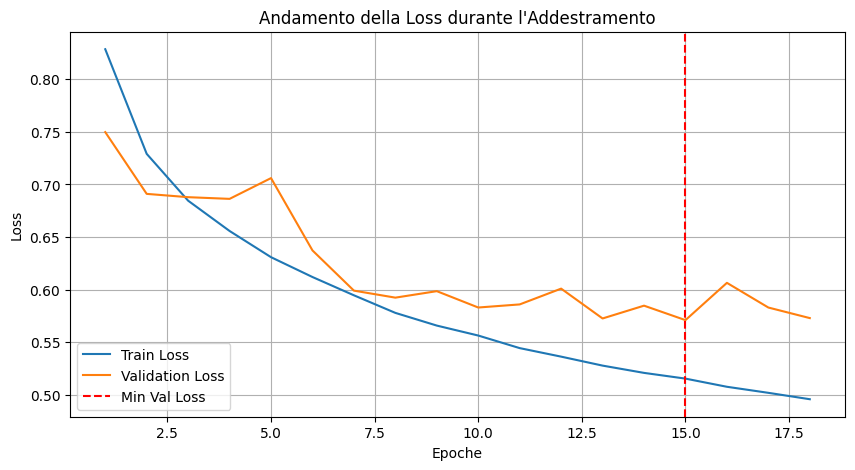

In [ ]:
'''
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
plt.plot(range(1, len(train_losses) + 1), train_losses, label='Train Loss')
plt.plot(range(1, len(val_losses) + 1), val_losses, label='Validation Loss')

# Evidenzia la minima perdita di validazione
min_val_loss = min(val_losses)
min_val_epoch = val_losses.index(min_val_loss) + 1
plt.axvline(min_val_epoch, linestyle='--', color='r', label='Min Val Loss')

plt.xlabel('Epoche')
plt.ylabel('Loss')
plt.title('Andamento della Loss durante l\'Addestramento')
plt.legend()
plt.grid(True)
plt.show()


✅ Funzione: estrazione degli embedding

In [ ]:
def extract_embeddings(model, dataloader, device):
    """
    Estrae gli embedding latenti delle molecole dal modello RNN (prima del layer fully-connected).
    Restituisce:
      - embeddings: lista di vettori [hidden_dim]
      - scores: lista dei docking scores associati
    """
    model.eval()
    embeddings = []
    scores = []

    with torch.no_grad():
        for batch in dataloader:
            sequences, docking_scores, lengths = batch
            sequences = sequences.to(device)

            # Embedding layer + LSTM
            embedded = model.embedding(sequences)  # [B, L, E]
            packed = nn.utils.rnn.pack_padded_sequence(
                embedded, lengths, batch_first=True, enforce_sorted=False
            )
            _, (hidden, _) = model.lstm(packed)
            last_hidden = hidden[-1]  # [B, H]

            embeddings.append(last_hidden.cpu())
            scores.extend([float(s) for s in docking_scores])

    # Concatena tutti gli embedding in un unico array
    all_embeddings = torch.cat(embeddings, dim=0).numpy()
    return all_embeddings, scores


In [ ]:
print("Test set size:", len(test_loader.dataset))
print("Intero dataset:", len(augmented_data))

Test set size: 60833
Intero dataset: 608322


In [ ]:
# Estrai gli embedding dal test set
test_embeddings, test_scores = extract_embeddings(model, test_loader, device)

# Salva come CSV
import pandas as pd
embedding_df = pd.DataFrame(test_embeddings)
embedding_df['docking_score'] = test_scores
embedding_df.to_csv("test_embeddings.csv", index=False)

print("Embedding molecolari salvati in 'test_embeddings.csv'")


Embedding molecolari salvati in 'test_embeddings.csv'


# Esempi di analisi  (sul test set):

Nel file in formato CSV ogni riga  corrisponde a una molecola;

le colonne sono costituite dalle componenti dell’embedding finale (hidden_dim) + docking_score

Il file può essere usato  per:

* analisi UMAP

* analisi t-SNE / PCA

* clustering

* ..training di un altro modello

* ..feature engineering

🟢 **UMAP – Uniform Manifold Approximation and Projection**

Un'alternativa moderna a t-SNE dalle seguenti caratterisitche in breve

* Anche non lineare, ma più veloce e meglio interpretabile globalmente

* Mantiene sia struttura locale che globale

* Supporta 2D, 3D o più dimensioni ancora

* Più scalabile rispetto a t-SNE

Molto usato in bioinformatica, chimica computazionale,ma anche nel  NLP

In [ ]:
!pip install umap-learn

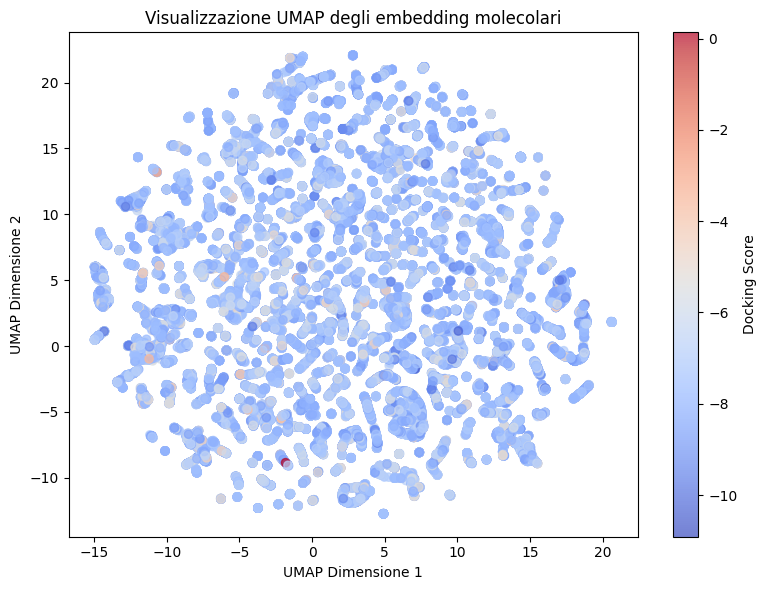

In [ ]:
# Esempio: carichiamo gli embedding dal file CSV e applichiamo UMAP
import pandas as pd
import umap
import matplotlib.pyplot as plt

# Caricamento degli embedding salvati
embedding_df = pd.read_csv("/content/test_embeddings.csv")

# Separazione degli embedding e del docking score
embedding_vectors = embedding_df.drop(columns=["docking_score"]).values
scores = embedding_df["docking_score"].values

# Applicazione di UMAP
# UMAP
umap_model = umap.UMAP(
    n_neighbors=15,
    min_dist=0.1,
    n_components=2,
    metric='euclidean',
    random_state=42
)
embedding_2d = umap_model.fit_transform(embedding_vectors)

# Visualizzazione
plt.figure(figsize=(8,6))
scatter = plt.scatter(embedding_2d[:, 0], embedding_2d[:, 1],
                      c=scores, cmap='coolwarm', alpha=0.7)
plt.colorbar(scatter, label="Docking Score")
plt.title("Visualizzazione UMAP degli embedding molecolari")
plt.xlabel("UMAP Dimensione 1")
plt.ylabel("UMAP Dimensione 2")
plt.tight_layout()
plt.show()


🟢**t-SNE (t-distributed Stochastic Neighbor Embedding)** E` una tecnica alternativa precedente a UMAP per proiettare dati ad alta dimensione in 2D o 3D, ottima per visualizzare la struttura locale negli embedding.
Parametri chiave di t-SNE

*Parametro*       	     |         Significato	 |   Valore tipico

---



*perplexity* |Influenza del numero di vicini da mantenere	|20–50 (30 è ottimo in media)

*n_iter*| Iterazioni dell’ottimizzazione|	1000–3000

*n_components*|	Numero di dimensioni di output (es. 2D) |	2

Affiancando UMAP per confronto si possono cercare elementi di paragone

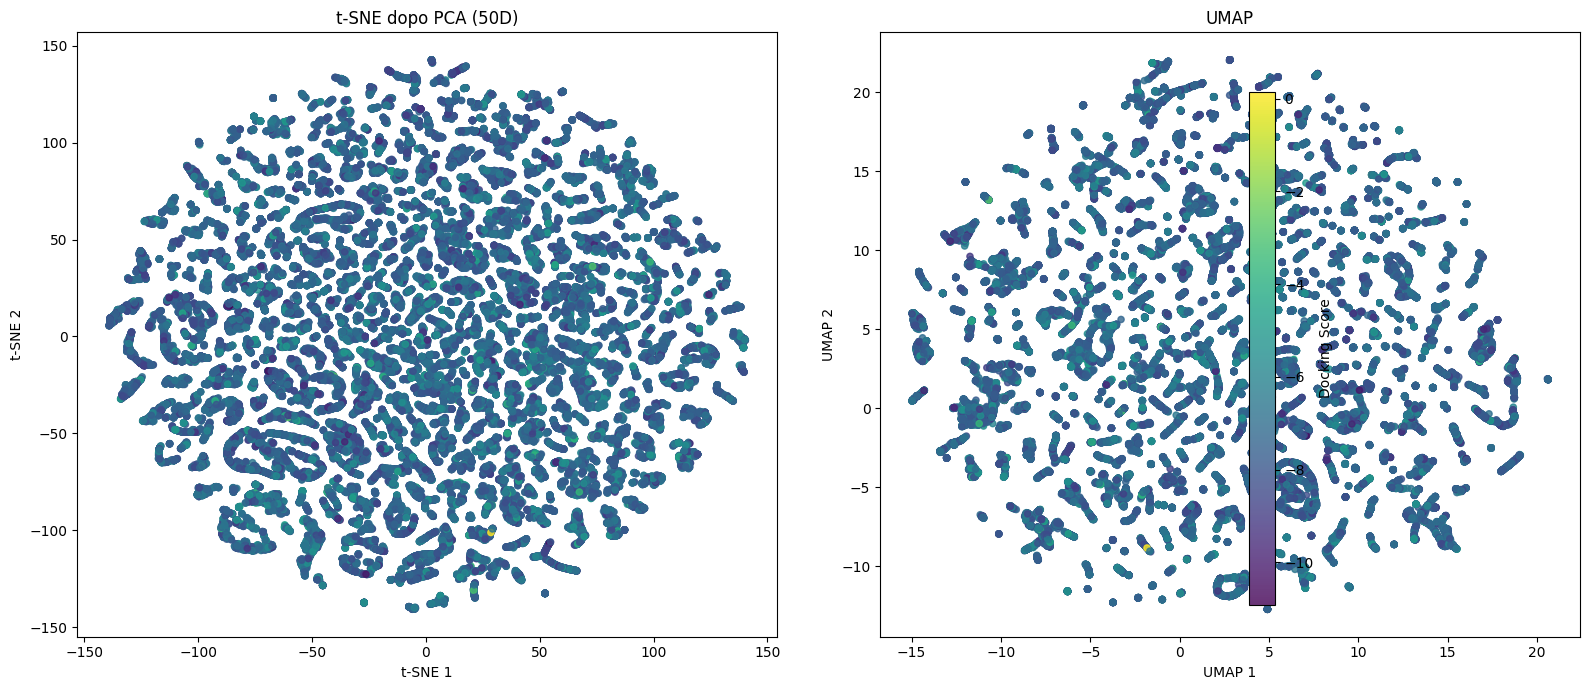

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import umap
import numpy as np

# Caricamento embeddings e docking score

embedding_vectors = embedding_df.drop(columns=["docking_score"]).values
scores = embedding_df["docking_score"].values

# === 1. PCA (dimensionality reduction a 50D per t-SNE) ===
pca = PCA(n_components=50, random_state=42)
pca_reduced = pca.fit_transform(embedding_vectors)

# === 2. t-SNE (su output PCA) ===
tsne = TSNE(n_components=2, perplexity=30, n_iter=1000, random_state=42)
embedding_tsne = tsne.fit_transform(pca_reduced)

# === 3. UMAP ===
umap_model = umap.UMAP(n_neighbors=15, min_dist=0.1, metric='euclidean', random_state=42)
embedding_umap = umap_model.fit_transform(embedding_vectors)

# === 4. Visualizzazione affiancata ===
fig, axes = plt.subplots(1, 2, figsize=(16, 7))

# t-SNE
sc1 = axes[0].scatter(embedding_tsne[:, 0], embedding_tsne[:, 1],
                      c=scores, cmap='viridis', s=20, alpha=0.8)
axes[0].set_title("t-SNE dopo PCA (50D)")
axes[0].set_xlabel("t-SNE 1")
axes[0].set_ylabel("t-SNE 2")

# UMAP
sc2 = axes[1].scatter(embedding_umap[:, 0], embedding_umap[:, 1],
                      c=scores, cmap='viridis', s=20, alpha=0.8)
axes[1].set_title("UMAP")
axes[1].set_xlabel("UMAP 1")
axes[1].set_ylabel("UMAP 2")

# Colorbar unica
fig.colorbar(sc2, ax=axes.ravel().tolist(), shrink=0.95, label="Docking Score")

plt.tight_layout()
plt.show()


🟢 Applichiamo anche KMeans e plottiamo la clusterizzazzione:

In [ ]:
from sklearn.cluster import KMeans

# Numero di cluster desiderati (puoi sperimentare: es. 4, 6, 10...)
k = 10
kmeans = KMeans(n_clusters=k, random_state=42)
cluster_labels = kmeans.fit_predict(embedding_umap)

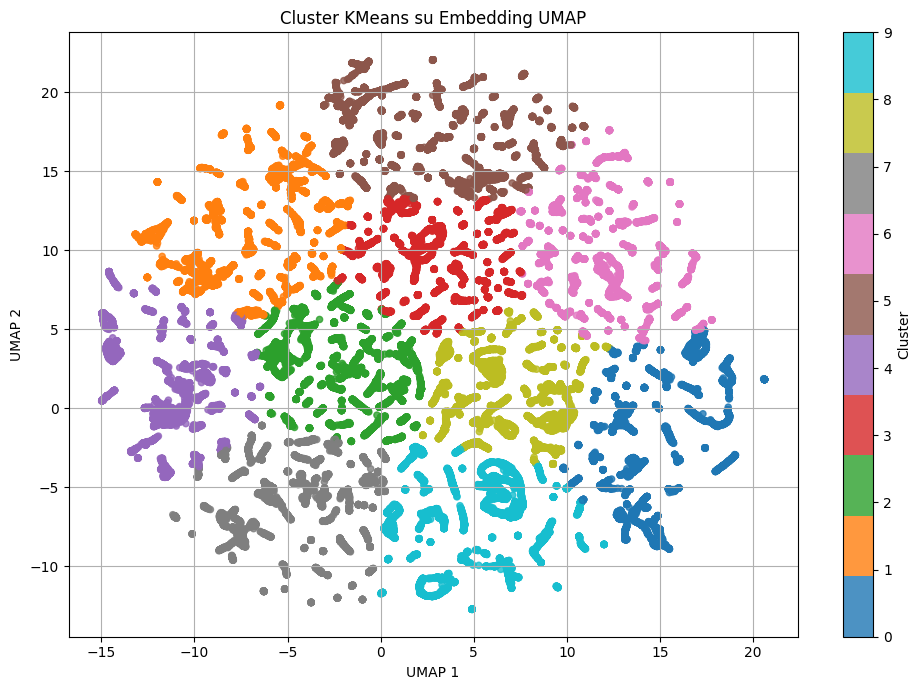

In [ ]:
plt.figure(figsize=(10, 7))
plt.scatter(embedding_umap[:, 0], embedding_umap[:, 1], c=cluster_labels, cmap='tab10', s=20, alpha=0.8)
plt.title("Cluster KMeans su Embedding UMAP")
plt.xlabel("UMAP 1")
plt.ylabel("UMAP 2")
plt.grid(True)
plt.colorbar(label="Cluster")
plt.tight_layout()
plt.show()

In [ ]:
import pandas as pd
umap_df = pd.DataFrame({
    "UMAP_1": embedding_umap[:, 0],
    "UMAP_2": embedding_umap[:, 1],
    "cluster": cluster_labels,
    "score": scores
})

# Calcola statistiche per cluster
cluster_stats = umap_df.groupby("cluster")["score"].describe()
display(cluster_stats)


,count,mean,std,min,25%,50%,75%,max
cluster,,,,,,,,
0,5964.0,-7.349989,0.948291,-10.9111,-7.973523,-7.420905,-6.831933,-3.094090
1,6937.0,-7.249201,0.986198,-10.3949,-7.907260,-7.341390,-6.707620,-0.596545
2,6842.0,-7.157602,1.008209,-10.5700,-7.839850,-7.271695,-6.602340,-1.462310
3,5895.0,-7.208976,1.010668,-10.4565,-7.885025,-7.310300,-6.640170,-2.739000
4,5341.0,-7.245590,0.991125,-10.1652,-7.922790,-7.330330,-6.685910,-0.284108
5,6028.0,-7.410680,0.956547,-10.6329,-8.040352,-7.480585,-6.857747,-0.515391
6,5490.0,-7.249057,0.994899,-10.9111,-7.909395,-7.328785,-6.681628,-0.794732
7,5829.0,-7.268699,1.014381,-10.4936,-7.937900,-7.375570,-6.714060,0.136049
8,6368.0,-7.339671,0.976676,-10.6476,-7.989815,-7.404120,-6.798318,-2.588650
